# Loading Libraries

In [9]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import pandas as pd

import torch.utils.data
from torch import optim
import os
import skfda
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import itertools 
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.neighbors import LocalOutlierFactor


mpl.rcParams['figure.dpi'] = 300


# Loading Files

In [10]:
def wf(x):
    return '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Data/' + x

In [11]:
V_GRF_stance_N = pd.read_csv(wf('V_GRF_stance_N.csv'), header = None)
ML_GRF_stance_N = pd.read_csv(wf('ML_GRF_stance_N.csv'), header = None)
AP_GRF_stance_N = pd.read_csv(wf('AP_GRF_stance_N.csv'), header = None)
ID_info = pd.read_csv(wf('IDinfo.csv'), header = None)

In [12]:
V_GRF_stance_N_matrix = V_GRF_stance_N.to_numpy()
ML_GRF_stance_N_matrix = ML_GRF_stance_N.to_numpy()
AP_GRF_stance_N_matrix = AP_GRF_stance_N.to_numpy()
ID_info_matrix = ID_info.to_numpy()

In [13]:
#Defining a list of grid points
grid_points_100 = list(range(1,101))
grid_points_2990 = list(range(1,2991))

In [14]:
V_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=V_GRF_stance_N_matrix,grid_points=grid_points_100)
V_GRF_stance_N_mean = skfda.exploratory.stats.mean(V_GRF_stance_N_fd)

ML_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=ML_GRF_stance_N_matrix,grid_points=grid_points_100)
ML_GRF_stance_N_mean = skfda.exploratory.stats.mean(ML_GRF_stance_N_fd)

AP_GRF_stance_N_fd = skfda.FDataGrid(data_matrix=AP_GRF_stance_N_matrix,grid_points=grid_points_100)
AP_GRF_stance_N_mean = skfda.exploratory.stats.mean(AP_GRF_stance_N_fd)

In [15]:
V_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = V_GRF_stance_N_mean.data_matrix[0,i,0]
        V_GRF_stance_N_mean_array[j,i] = val
    
ML_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = ML_GRF_stance_N_mean.data_matrix[0,i,0]
        ML_GRF_stance_N_mean_array[j,i] = val
    
AP_GRF_stance_N_mean_array = np.zeros((15696,100))
for j in range(0,15696):
    for i in range(0,100):
        val = AP_GRF_stance_N_mean.data_matrix[0,i,0]
        AP_GRF_stance_N_mean_array[j,i] = val

# Defining VAE

In [16]:
class InfoVAE(nn.Module):
    def __init__(self,nfeat=100, ncode=5, alpha=0, lambd=10000, nhidden=128, nhidden2=35, dropout=0.2):
        super(InfoVAE, self).__init__()
        
        self.ncode = int(ncode)
        self.alpha = float(alpha)
        self.lambd = float(lambd)
        
        self.encd = nn.Linear(nfeat, nhidden)
        self.d1 = nn.Dropout(p=dropout)
        self.enc2 = nn.Linear(nhidden, nhidden2)
        self.d2 = nn.Dropout(p=dropout)
        self.mu = nn.Linear(nhidden2, ncode)
        self.lv = nn.Linear(nhidden2, ncode)
        
        self.decd = nn.Linear(ncode, nhidden2)
        self.d3 = nn.Dropout(p=dropout)
        self.dec2 = nn.Linear(nhidden2, nhidden)
        self.d4 = nn.Dropout(p=dropout)
        self.outp = nn.Linear(nhidden, nfeat)
        
    def encode(self, x):
        x = self.d1(F.leaky_relu(self.encd(x)))
        x = self.d2(F.leaky_relu(self.enc2(x)))
        mu = self.mu(x)
        logvar = self.lv(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, x):
        x = self.d3(F.leaky_relu(self.decd(x)))
        x = self.d4(F.leaky_relu(self.dec2(x)))
        x = self.outp(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_kernel(self, x, y):
        x_size = x.size(0)
        y_size = y.size(0)
        dim = x.size(1)
        x = x.unsqueeze(1) # (x_size, 1, dim)
        y = y.unsqueeze(0) # (1, y_size, dim)
        tiled_x = x.expand(x_size, y_size, dim)
        tiled_y = y.expand(x_size, y_size, dim)
        # The example code divides by (dim) here, making <kernel_input> ~ 1/dim
        # excluding (dim) makes <kernel_input> ~ 1
        kernel_input = (tiled_x - tiled_y).pow(2).mean(2)#/float(dim)
        return torch.exp(-kernel_input) # (x_size, y_size)
    
    # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
    def compute_mmd(self, x, y):
        xx_kernel = self.compute_kernel(x,x)
        yy_kernel = self.compute_kernel(y,y)
        xy_kernel = self.compute_kernel(x,y)
        return torch.mean(xx_kernel) + torch.mean(yy_kernel) - 2*torch.mean(xy_kernel)
    
    def loss(self, x, epoch):
        recon_x, mu, logvar = self.forward(x)
        MSE = torch.sum(0.5 *  (x - recon_x).pow(2))
        
        # KL divergence (Kingma and Welling, https://arxiv.org/abs/1312.6114, Appendix B)
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        #return MSE + self.beta*KLD, MSE
                
        # https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/
        true_samples = Variable(torch.randn(200, self.ncode), requires_grad=False)
        z = self.reparameterize(mu, logvar) #duplicate call
        # compute MMD ~ 1, so upweight to match KLD which is ~ n_batch x n_code
        MMD = self.compute_mmd(true_samples,z) * x.size(0) * self.ncode
        return MSE + (1-self.alpha)*KLD + (self.lambd+self.alpha-1)*MMD, MSE, KLD, MMD

# Preparing Test and Train datasets for model fitting

# VGRF

In [17]:
trainfrac = 0.75
ntrain = int(V_GRF_stance_N_matrix.shape[0] * trainfrac)
nvalid = V_GRF_stance_N_matrix.shape[0] - ntrain
nfeat = V_GRF_stance_N_matrix.shape[1]
np.random.seed(20190425) # make validation set deterministic
permutation = np.random.permutation(V_GRF_stance_N_matrix.shape[0])
np.random.seed()
trainidx = permutation[0:ntrain]
valididx = permutation[-1-nvalid:-1]

train_vgrf = V_GRF_stance_N_matrix[trainidx,:]
valid_vgrf = V_GRF_stance_N_matrix[valididx,:]

In [18]:
batch_size=64

dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_vgrf, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True)

valdloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(valid_vgrf, dtype=torch.float32)),
    batch_size=nvalid)

## Defining Training function

In [19]:
def train(): #model, optimizer, epoch, min_valid_loss, badepochs
    model.train()
    train_loss = 0
    train_logL = 0
    for batch_idx, data in enumerate(dataloader):
        spectrum = data[0]
        optimizer.zero_grad()
        loss, logL, KLD, MMD = model.loss(spectrum, epoch)
        loss.backward()
        train_loss += loss.item()
        train_logL += logL.item()
        optimizer.step()
    train_loss /= len(dataloader.dataset)
    
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        valid_logL = 0
        valid_KLD = 0
        valid_MMD = 0

        for valddata in valdloader:
            spectrum = valddata[0]
            loss, logL, KLD, MMD = model.loss(spectrum, epoch)
            valid_loss += loss.item()
            valid_logL += logL.item()
            valid_KLD += KLD.item()
            valid_MMD += MMD.item()
        
        valid_loss /= len(valdloader.dataset)
        valid_logL /= -len(valdloader.dataset)
        valid_KLD  /= len(valdloader.dataset)
        valid_MMD  /= len(valdloader.dataset)
    return valid_loss, valid_logL, valid_KLD, valid_MMD

In [20]:
class EarlyStopper:
    def __init__(self, precision=1e-3, patience=10):
        self.precision = precision
        self.patience = patience
        self.badepochs = 0
        self.min_valid_loss = float('inf')
        
    def step(self, valid_loss):
        if valid_loss < self.min_valid_loss*(1-self.precision):
            self.badepochs = 0
            self.min_valid_loss = valid_loss
        else:
            self.badepochs += 1
        return not (self.badepochs == self.patience)

# Setting training parameters

In [21]:
epochs = 200
log_interval = 10
mdl_ncode_l = range(2,11,2)
n_config_l = range(100)
test_list = [n_config_l,mdl_ncode_l]

mdl_MSE = np.zeros((100, 5))
mdl_KLD = np.zeros((100, 5))
mdl_MMD = np.zeros((100, 5))

In [22]:
tag = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz'
# Parent Directory path
parent_dir = '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/'
# Path

# Training 100 models for 5 different encoder shapes

In [143]:
for config, mdl_ncode in itertools.product(n_config_l,mdl_ncode_l):
    alpha = 0
    lambd = np.exp(np.random.uniform(0, np.log(1e5)))
    dropout = 0#0.9*np.random.uniform()
    dfac = 1./(1.-dropout)
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(dfac*2*nfeat)))))
    nhidden2 = int(np.ceil(np.exp(np.random.uniform(np.log(dfac*mdl_ncode+1), np.log(nhidden)))))
    print('config %i, alpha = %0.1f, lambda = %0.1f, dropout = %0.2f; 2 hidden layers with %i, %i nodes' % (config, alpha, lambd, dropout, nhidden, nhidden2))
    model = InfoVAE(alpha=alpha, lambd=lambd, nfeat=nfeat, nhidden=nhidden, nhidden2=nhidden2, ncode=mdl_ncode, dropout=dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=5)
    stopper = EarlyStopper(patience=10)

    for epoch in range(1, epochs + 1):
        valid_loss, valid_logL, valid_KLD, valid_MMD = train()
        if epoch % log_interval == 0:
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))

        scheduler.step(valid_loss)
        if (not stopper.step(valid_loss)) or (epoch == epochs):
            
            if mdl_ncode == 2:
                p_i = 0
            elif mdl_ncode == 4:
                p_i = 1
            elif mdl_ncode == 6:
                p_i = 2
            elif mdl_ncode == 8:
                p_i = 3
            elif mdl_ncode == 10:
                p_i = 4
                
            print('Stopping')
            print('====> Epoch: {} VALIDATION Loss: {:.2e} logL: {:.2e} KL: {:.2e} MMD: {:.2e}'.format(
                  epoch, valid_loss, valid_logL, valid_KLD, valid_MMD))
            model.MSE = -valid_logL
            model.KLD = valid_KLD
            model.MMD = valid_MMD
            mdl_MSE[config,p_i] = model.MSE
            mdl_KLD[config,p_i] = model.KLD
            mdl_MMD[config,p_i] = model.MMD
            torch.save(model, tag +'/%i' % mdl_ncode +'/%04i.pth' % config  )
            break


config 0, alpha = 0.0, lambda = 7.9, dropout = 0.00; 2 hidden layers with 11, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 0, alpha = 0.0, lambda = 66946.9, dropout = 0.00; 2 hidden layers with 9, 7 nodes
====> Epoch: 10 VALIDATION Loss: 2.34e+07 logL: -2.33e+07 KL: 6.90e+03 MMD: 1.05e+00
====> Epoch: 20 VALIDATION Loss: 1.24e+06 logL: -1.16e+06 KL: 9.10e+03 MMD: 1.07e+00
====> Epoch: 30 VALIDATION Loss: 6.21e+05 logL: -5.46e+05 KL: 5.92e+03 MMD: 1.03e+00
====> Epoch: 40 VALIDATION Loss: 3.95e+05 logL: -3.26e+05 KL: 4.26e+03 MMD: 9.67e-01
Epoch 00047: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 50 VALIDATION Loss: 3.94e+05 logL: -3.24e+05 KL: 4.07e+03 MMD: 9.95e-01
Epoch 00054: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 60 VALIDATION Loss: 3.98e+05 logL: -3.23e+05 KL: 4.06e+03 MMD: 1

====> Epoch: 20 VALIDATION Loss: 9.09e+04 logL: -7.79e+04 KL: 7.63e+03 MMD: 1.04e+00
====> Epoch: 30 VALIDATION Loss: 7.74e+04 logL: -6.65e+04 KL: 5.80e+03 MMD: 1.00e+00
====> Epoch: 40 VALIDATION Loss: 6.61e+04 logL: -5.59e+04 KL: 4.93e+03 MMD: 1.03e+00
====> Epoch: 50 VALIDATION Loss: 6.03e+04 logL: -5.07e+04 KL: 4.55e+03 MMD: 9.83e-01
Epoch 00059: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 60 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 60 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 3, alpha = 0.0, lambda = 306.8, dropout = 0.00; 2 hidden layers with 55, 13 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 3, alpha = 0.0, lambda = 539.6, dropout = 0.00; 2 hidden layers with 73, 10 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDA

====> Epoch: 170 VALIDATION Loss: 1.17e+05 logL: -1.14e+05 KL: 2.50e+03 MMD: 7.02e-01
====> Epoch: 180 VALIDATION Loss: 1.18e+05 logL: -1.14e+05 KL: 2.42e+03 MMD: 7.26e-01
====> Epoch: 190 VALIDATION Loss: 1.17e+05 logL: -1.14e+05 KL: 2.33e+03 MMD: 6.71e-01
Epoch 00193: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 200 VALIDATION Loss: 1.17e+05 logL: -1.14e+05 KL: 2.28e+03 MMD: 6.98e-01
Epoch 00200: reducing learning rate of group 0 to 1.0000e-06.
Stopping
====> Epoch: 200 VALIDATION Loss: 1.17e+05 logL: -1.14e+05 KL: 2.28e+03 MMD: 6.98e-01
config 7, alpha = 0.0, lambda = 16.7, dropout = 0.00; 2 hidden layers with 178, 85 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 7, alpha = 0.0, lambda = 74.4, dropout = 0.00; 2 hidden layers with 13, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.


====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 11, alpha = 0.0, lambda = 31.3, dropout = 0.00; 2 hidden layers with 62, 9 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 11, alpha = 0.0, lambda = 43415.1, dropout = 0.00; 2 hidden layers with 151, 34 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 11, alpha = 0.0, lambda = 28.8, dropout = 0.00; 2 hidden layers with 109, 52 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD:

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 14, alpha = 0.0, lambda = 29.1, dropout = 0.00; 2 hidden layers with 25, 16 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 14, alpha = 0.0, lambda = 2.7, dropout = 0.00; 2 hidden layers with 72, 19 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 15, alpha = 0.0, lambda = 22714.2, dropout = 0.00; 2 hidden layers with 7, 4 nodes
====> Epoch: 10 VALIDATION Loss: 2.70e+07 logL: -2.42e+07 KL: 2.85e+06 MMD: 6.85e-01
====> Epoch: 20 VALIDATION Loss: 2.44e+07 logL: -2.

====> Epoch: 10 VALIDATION Loss: 5.29e+05 logL: -3.00e+05 KL: 2.21e+05 MMD: 7.20e-01
====> Epoch: 20 VALIDATION Loss: 3.57e+05 logL: -2.91e+05 KL: 5.78e+04 MMD: 6.85e-01
====> Epoch: 30 VALIDATION Loss: 3.21e+05 logL: -2.88e+05 KL: 2.36e+04 MMD: 7.58e-01
====> Epoch: 40 VALIDATION Loss: 3.08e+05 logL: -2.87e+05 KL: 1.30e+04 MMD: 6.82e-01
====> Epoch: 50 VALIDATION Loss: 3.01e+05 logL: -2.85e+05 KL: 7.98e+03 MMD: 6.85e-01
====> Epoch: 60 VALIDATION Loss: 2.97e+05 logL: -2.83e+05 KL: 5.25e+03 MMD: 6.90e-01
====> Epoch: 70 VALIDATION Loss: 2.94e+05 logL: -2.83e+05 KL: 3.66e+03 MMD: 6.79e-01
====> Epoch: 80 VALIDATION Loss: 2.62e+05 logL: -2.51e+05 KL: 2.55e+03 MMD: 6.70e-01
====> Epoch: 90 VALIDATION Loss: 1.34e+05 logL: -1.22e+05 KL: 2.68e+03 MMD: 7.33e-01
====> Epoch: 100 VALIDATION Loss: 1.30e+05 logL: -1.19e+05 KL: 2.20e+03 MMD: 6.83e-01
Epoch 00108: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 110 VALIDATION Loss: 1.27e+05 logL: -1.17e+05 KL: 1.88e+03 MMD: 6.76e-01
=

====> Epoch: 110 VALIDATION Loss: 9.39e+04 logL: -7.42e+04 KL: 4.03e+03 MMD: 1.04e+00
====> Epoch: 120 VALIDATION Loss: 9.11e+04 logL: -7.14e+04 KL: 3.64e+03 MMD: 1.06e+00
Epoch 00120: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00128: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 130 VALIDATION Loss: 8.92e+04 logL: -7.09e+04 KL: 3.53e+03 MMD: 9.78e-01
Stopping
====> Epoch: 132 VALIDATION Loss: 9.04e+04 logL: -7.10e+04 KL: 3.52e+03 MMD: 1.06e+00
config 20, alpha = 0.0, lambda = 17.4, dropout = 0.00; 2 hidden layers with 83, 11 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 20, alpha = 0.0, lambda = 82.2, dropout = 0.00; 2 hidden layers with 99, 84 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 23, alpha = 0.0, lambda = 1.1, dropout = 0.00; 2 hidden layers with 9, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 23, alpha = 0.0, lambda = 350.9, dropout = 0.00; 2 hidden layers with 8, 8 nodes
====> Epoch: 10 VALIDATION Loss: 2.99e+05 logL: -2.93e+05 KL: 5.43e+03 MMD: 1.47e+00
====> Epoch: 20 VALIDATION Loss: 2.95e+05 logL: -2.89e+05 KL: 5.26e+03 MMD: 1.63e+00
====> Epoch: 30 VALIDATION Loss: 2.82e+05 logL: -2.77e+05 KL: 4.48e+03 MMD: 1.43e+00
====> Epoch: 40 VALIDATION Loss: 2.78e+05 logL: -2.74e+05 KL: 3.48e+03 MMD: 1.54e+00
====> Epoch: 50 VALIDATION Loss: 2.76e+05 logL: -2.73e+05 KL: 2.60e+03 MMD: 1.50e+00
===

Epoch 00157: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 159 VALIDATION Loss: 1.35e+05 logL: -1.15e+05 KL: 2.48e+03 MMD: 1.04e+00
config 26, alpha = 0.0, lambda = 1303.6, dropout = 0.00; 2 hidden layers with 18, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 26, alpha = 0.0, lambda = 42848.2, dropout = 0.00; 2 hidden layers with 19, 10 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 26, alpha = 0.0, lambda = 19.9, dropout = 0.00; 2 hidden layers with 12, 12 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan lo

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 30, alpha = 0.0, lambda = 3.6, dropout = 0.00; 2 hidden layers with 80, 66 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 31, alpha = 0.0, lambda = 1.2, dropout = 0.00; 2 hidden layers with 79, 20 nodes
====> Epoch: 10 VALIDATION Loss: 2.36e+07 logL: -2.36e+07 KL: 2.08e+03 MMD: 6.74e-01
====> Epoch: 20 VALIDATION Loss: 2.35e+07 logL: -2.35e+07 KL: 1.74e+04 MMD: 7.08e-01
====> Epoch: 30 VALIDATION Loss: 2.33e+07 logL: -2.33e+07 KL: 4.14e+04 MMD: 6.70e-01
====> Epoch: 40 VALIDATION Loss: 2.32e+07 logL: -2.31e+07 KL: 8.61e+04 MMD: 7.12e-01
====> Epoch: 50 VALIDATION Loss: 1.88e+07 logL: -1.70e+07 KL: 1.79e+06 MMD: 6.33e-01
=

====> Epoch: 110 VALIDATION Loss: 1.38e+05 logL: -1.25e+05 KL: 7.42e+03 MMD: 9.95e-01
====> Epoch: 120 VALIDATION Loss: 1.32e+05 logL: -1.20e+05 KL: 5.96e+03 MMD: 1.05e+00
====> Epoch: 130 VALIDATION Loss: 1.27e+05 logL: -1.17e+05 KL: 4.36e+03 MMD: 1.01e+00
====> Epoch: 140 VALIDATION Loss: 1.16e+05 logL: -1.08e+05 KL: 3.07e+03 MMD: 9.94e-01
====> Epoch: 150 VALIDATION Loss: 1.03e+05 logL: -9.52e+04 KL: 2.51e+03 MMD: 9.72e-01
====> Epoch: 160 VALIDATION Loss: 6.52e+04 logL: -5.68e+04 KL: 2.55e+03 MMD: 1.03e+00
====> Epoch: 170 VALIDATION Loss: 6.04e+04 logL: -5.19e+04 KL: 2.43e+03 MMD: 1.08e+00
====> Epoch: 180 VALIDATION Loss: 5.89e+04 logL: -5.07e+04 KL: 2.49e+03 MMD: 1.01e+00
Epoch 00183: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 190 VALIDATION Loss: 5.77e+04 logL: -4.99e+04 KL: 2.27e+03 MMD: 9.85e-01
Epoch 00197: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 200 VALIDATION Loss: 5.72e+04 logL: -4.98e+04 KL: 2.09e+03 MMD: 9.31e-01
Stopping
====> E

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 37, alpha = 0.0, lambda = 12.5, dropout = 0.00; 2 hidden layers with 23, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 37, alpha = 0.0, lambda = 19.3, dropout = 0.00; 2 hidden layers with 10, 9 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 37, alpha = 0.0, lambda = 32.2, dropout = 0.00; 2 hidden layers with 14, 13 nodes
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: 1.49e+25 logL: -7.25e+23 KL: 1.42e+25 MMD: 

====> Epoch: 100 VALIDATION Loss: 2.78e+05 logL: -2.74e+05 KL: 2.63e+03 MMD: 7.80e-01
====> Epoch: 110 VALIDATION Loss: 2.77e+05 logL: -2.74e+05 KL: 2.23e+03 MMD: 7.82e-01
====> Epoch: 120 VALIDATION Loss: 2.76e+05 logL: -2.74e+05 KL: 1.94e+03 MMD: 7.62e-01
====> Epoch: 130 VALIDATION Loss: 2.76e+05 logL: -2.73e+05 KL: 1.73e+03 MMD: 7.65e-01
Stopping
====> Epoch: 139 VALIDATION Loss: 2.77e+05 logL: -2.74e+05 KL: 1.57e+03 MMD: 8.99e-01
config 41, alpha = 0.0, lambda = 145.3, dropout = 0.00; 2 hidden layers with 15, 7 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 41, alpha = 0.0, lambda = 8123.6, dropout = 0.00; 2 hidden layers with 92, 12 nodes
====> Epoch: 10 VALIDATION Loss: 3.31e+05 logL: -2.75e+05 KL: 4.36e+04 MMD: 1.49e+00
====> Epoch: 20 VALIDATION Loss: 1.96e+17 logL: -1.73e+17 KL: 2.30e+16 MMD: 1.22e+00
Epoch 00025:

====> Epoch: 20 VALIDATION Loss: 2.93e+05 logL: -2.76e+05 KL: 1.44e+04 MMD: 1.04e+00
====> Epoch: 30 VALIDATION Loss: 2.83e+05 logL: -2.74e+05 KL: 6.78e+03 MMD: 9.81e-01
====> Epoch: 40 VALIDATION Loss: 1.74e+05 logL: -1.67e+05 KL: 5.31e+03 MMD: 1.02e+00
====> Epoch: 50 VALIDATION Loss: 1.33e+05 logL: -1.26e+05 KL: 5.25e+03 MMD: 1.01e+00
Epoch 00054: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 58 VALIDATION Loss: 1.24e+05 logL: -1.17e+05 KL: 4.62e+03 MMD: 1.03e+00
config 45, alpha = 0.0, lambda = 82997.2, dropout = 0.00; 2 hidden layers with 12, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 45, alpha = 0.0, lambda = 81285.8, dropout = 0.00; 2 hidden layers with 172, 74 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD:

====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 49, alpha = 0.0, lambda = 6.4, dropout = 0.00; 2 hidden layers with 19, 13 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 49, alpha = 0.0, lambda = 14252.4, dropout = 0.00; 2 hidden layers with 37, 26 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 50, alpha = 0.0, lambda = 13246.4, dropout = 0.00; 2 hidden layers with 12, 7 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD:

====> Epoch: 10 VALIDATION Loss: 2.90e+05 logL: -2.74e+05 KL: 1.58e+04 MMD: 1.03e+00
====> Epoch: 20 VALIDATION Loss: 2.85e+05 logL: -2.74e+05 KL: 1.05e+04 MMD: 1.15e+00
====> Epoch: 30 VALIDATION Loss: 2.80e+05 logL: -2.73e+05 KL: 6.11e+03 MMD: 1.10e+00
====> Epoch: 40 VALIDATION Loss: 2.77e+05 logL: -2.73e+05 KL: 3.41e+03 MMD: 1.20e+00
====> Epoch: 50 VALIDATION Loss: 2.76e+05 logL: -2.73e+05 KL: 2.09e+03 MMD: 1.37e+00
====> Epoch: 60 VALIDATION Loss: 2.75e+05 logL: -2.73e+05 KL: 1.52e+03 MMD: 1.38e+00
Stopping
====> Epoch: 63 VALIDATION Loss: 2.75e+05 logL: -2.73e+05 KL: 1.42e+03 MMD: 1.34e+00
config 53, alpha = 0.0, lambda = 66132.1, dropout = 0.00; 2 hidden layers with 32, 28 nodes
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: 4.99e+20 logL: -1.66e+19 KL: 4.82e+20 MMD: 1.26e+00
Stopping
====> Epoch: 12 VALIDATION Loss: 4.91e+20 logL: -9.13e+18 KL: 4.82e+20 MMD: 1.28e+00
config 53, alpha = 0.0, lambda = 2607.0, dropout = 0.00; 2 hidd

====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 56, alpha = 0.0, lambda = 82.7, dropout = 0.00; 2 hidden layers with 8, 6 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 56, alpha = 0.0, lambda = 10.1, dropout = 0.00; 2 hidden layers with 8, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 56, alpha = 0.0, lambda = 78.5, dropout = 0.00; 2 hidden layers with 54, 11 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
con

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 61, alpha = 0.0, lambda = 1.8, dropout = 0.00; 2 hidden layers with 49, 14 nodes
====> Epoch: 10 VALIDATION Loss: 2.53e+07 logL: -2.41e+07 KL: 1.27e+06 MMD: 8.67e-01
====> Epoch: 20 VALIDATION Loss: 2.42e+07 logL: -2.37e+07 KL: 5.39e+05 MMD: 1.00e+00
====> Epoch: 30 VALIDATION Loss: 2.38e+07 logL: -2.35e+07 KL: 2.34e+05 MMD: 1.05e+00
====> Epoch: 40 VALIDATION Loss: 2.30e+07 logL: -2.29e+07 KL: 1.33e+05 MMD: 9.91e-01
====> Epoch: 50 VALIDATION Loss: 1.13e+06 logL: -9.66e+05 KL: 1.68e+05 MMD: 9.87e-01
====> Epoch: 60 VALIDATION Loss: 3.74e+05 logL: -2.84e+05 KL: 9.00e+04 MMD: 1.10e+00
====> Epoch: 70 VALIDATION Loss: 3.27e+05 logL: -2.78e+05 KL: 4.89e+04 MMD: 9.65e-01
====> Epoch: 80 VALIDATION Loss: 3.05e+05 logL: -2.78e+05 KL: 2.71e+04 MMD: 1.07e+00
====> Epoch: 90 VALIDATION Loss: 

====> Epoch: 50 VALIDATION Loss: 1.27e+05 logL: -1.20e+05 KL: 6.49e+03 MMD: 6.66e-01
====> Epoch: 60 VALIDATION Loss: 1.25e+05 logL: -1.20e+05 KL: 4.43e+03 MMD: 7.19e-01
====> Epoch: 70 VALIDATION Loss: 1.23e+05 logL: -1.19e+05 KL: 3.42e+03 MMD: 6.98e-01
====> Epoch: 80 VALIDATION Loss: 1.22e+05 logL: -1.19e+05 KL: 2.76e+03 MMD: 6.84e-01
====> Epoch: 90 VALIDATION Loss: 1.22e+05 logL: -1.19e+05 KL: 2.35e+03 MMD: 6.72e-01
====> Epoch: 100 VALIDATION Loss: 1.21e+05 logL: -1.19e+05 KL: 2.06e+03 MMD: 7.20e-01
====> Epoch: 110 VALIDATION Loss: 1.22e+05 logL: -1.20e+05 KL: 1.85e+03 MMD: 7.01e-01
====> Epoch: 120 VALIDATION Loss: 1.20e+05 logL: -1.18e+05 KL: 1.69e+03 MMD: 6.51e-01
====> Epoch: 130 VALIDATION Loss: 1.20e+05 logL: -1.18e+05 KL: 1.59e+03 MMD: 5.97e-01
====> Epoch: 140 VALIDATION Loss: 1.19e+05 logL: -1.17e+05 KL: 1.52e+03 MMD: 6.66e-01
====> Epoch: 150 VALIDATION Loss: 1.18e+05 logL: -1.16e+05 KL: 1.48e+03 MMD: 7.19e-01
====> Epoch: 160 VALIDATION Loss: 1.17e+05 logL: -1.15e+05 

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 67, alpha = 0.0, lambda = 45338.6, dropout = 0.00; 2 hidden layers with 56, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 67, alpha = 0.0, lambda = 1.0, dropout = 0.00; 2 hidden layers with 47, 22 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 67, alpha = 0.0, lambda = 33.5, dropout = 0.00; 2 hidden layers with 20, 20 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping


Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 71, alpha = 0.0, lambda = 1.2, dropout = 0.00; 2 hidden layers with 39, 13 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 72, alpha = 0.0, lambda = 190.7, dropout = 0.00; 2 hidden layers with 32, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 72, alpha = 0.0, lambda = 3.8, dropout = 0.00; 2 hidden layers with 116, 99 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
==

====> Epoch: 20 VALIDATION Loss: 1.77e+30 logL: -1.75e+30 KL: 1.52e+28 MMD: 1.13e+00
Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
Stopping
====> Epoch: 27 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 75, alpha = 0.0, lambda = 41.4, dropout = 0.00; 2 hidden layers with 10, 8 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 75, alpha = 0.0, lambda = 12.4, dropout = 0.00; 2 hidden layers with 26, 15 nodes
====> Epoch: 10 VALIDATION Loss: 3.62e+05 logL: -3.06e+05 KL: 5.59e+04 MMD: 1.77e+00
====> Epoch: 20 VALIDATION Loss: 3.02e+05 logL: -2.83e+05 KL: 1.81e+04 MMD: 1.65e+00
====> Epoch: 30 VALIDATION Loss: 2.87e+05 logL: -2.78e+05 KL: 9.03e+03 MMD: 1.68e+00
====> Epoch: 40 VALIDATION Loss: 2.80e+05 logL: -2.75e+05 KL: 5.14e+03 MMD: 1.70e+00
====> Epoch: 50 VALIDATION Loss: 1.27e+05 logL: -1.22e+05 KL: 4.

Stopping
====> Epoch: 67 VALIDATION Loss: 1.22e+05 logL: -1.14e+05 KL: 2.00e+03 MMD: 6.53e-01
config 78, alpha = 0.0, lambda = 1266.3, dropout = 0.00; 2 hidden layers with 103, 6 nodes
====> Epoch: 10 VALIDATION Loss: 1.91e+07 logL: -1.90e+07 KL: 9.16e+04 MMD: 9.90e-01
====> Epoch: 20 VALIDATION Loss: 1.74e+07 logL: -1.73e+07 KL: 7.44e+04 MMD: 1.04e+00
====> Epoch: 30 VALIDATION Loss: 3.74e+05 logL: -3.58e+05 KL: 1.46e+04 MMD: 1.04e+00
====> Epoch: 40 VALIDATION Loss: 3.16e+05 logL: -3.01e+05 KL: 1.38e+04 MMD: 1.05e+00
====> Epoch: 50 VALIDATION Loss: 3.04e+05 logL: -2.89e+05 KL: 1.30e+04 MMD: 1.05e+00
====> Epoch: 60 VALIDATION Loss: 2.96e+05 logL: -2.83e+05 KL: 1.15e+04 MMD: 1.08e+00
====> Epoch: 70 VALIDATION Loss: 2.91e+05 logL: -2.79e+05 KL: 1.02e+04 MMD: 1.09e+00
====> Epoch: 80 VALIDATION Loss: 2.86e+05 logL: -2.77e+05 KL: 7.67e+03 MMD: 1.11e+00
====> Epoch: 90 VALIDATION Loss: 2.82e+05 logL: -2.75e+05 KL: 6.23e+03 MMD: 1.10e+00
====> Epoch: 100 VALIDATION Loss: 2.80e+05 logL: -

====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 81, alpha = 0.0, lambda = 56354.1, dropout = 0.00; 2 hidden layers with 87, 14 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 82, alpha = 0.0, lambda = 85.3, dropout = 0.00; 2 hidden layers with 4, 4 nodes
====> Epoch: 10 VALIDATION Loss: 3.09e+05 logL: -3.06e+05 KL: 2.86e+03 MMD: 6.15e-01
====> Epoch: 20 VALIDATION Loss: 2.83e+05 logL: -2.80e+05 KL: 2.54e+03 MMD: 6.68e-01
====> Epoch: 30 VALIDATION Loss: 2.78e+05 logL: -2.75e+05 KL: 2.33e+03 MMD: 7.20e-01
====> Epoch: 40 VALIDATION Loss: 2.76e+05 logL: -2.74e+05 KL: 2.07e+03 MMD: 7.29e-01
====> Epoch: 50 VALIDATION Loss: 2.75e+05 logL: -2.73e+05 KL: 1.68e+03 MMD: 6.41e-01
====> Epoch: 60 VALIDATION Loss: 2.74e+05 logL: -2.73e+05 KL

====> Epoch: 10 VALIDATION Loss: 3.27e+05 logL: -2.76e+05 KL: 4.87e+04 MMD: 6.21e-01
====> Epoch: 20 VALIDATION Loss: 1.91e+05 logL: -1.76e+05 KL: 1.29e+04 MMD: 6.53e-01
====> Epoch: 30 VALIDATION Loss: 1.32e+05 logL: -1.23e+05 KL: 7.65e+03 MMD: 6.54e-01
====> Epoch: 40 VALIDATION Loss: 1.27e+05 logL: -1.20e+05 KL: 4.96e+03 MMD: 6.61e-01
====> Epoch: 50 VALIDATION Loss: 1.24e+05 logL: -1.18e+05 KL: 3.72e+03 MMD: 7.04e-01
====> Epoch: 60 VALIDATION Loss: 1.22e+05 logL: -1.17e+05 KL: 2.94e+03 MMD: 6.86e-01
====> Epoch: 70 VALIDATION Loss: 1.21e+05 logL: -1.16e+05 KL: 2.48e+03 MMD: 7.13e-01
Epoch 00078: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 80 VALIDATION Loss: 1.19e+05 logL: -1.15e+05 KL: 2.18e+03 MMD: 6.80e-01
====> Epoch: 90 VALIDATION Loss: 1.19e+05 logL: -1.15e+05 KL: 2.13e+03 MMD: 7.25e-01
Epoch 00097: reducing learning rate of group 0 to 1.0000e-05.
====> Epoch: 100 VALIDATION Loss: 1.19e+05 logL: -1.15e+05 KL: 2.08e+03 MMD: 6.39e-01
Epoch 00106: reducing lea

====> Epoch: 60 VALIDATION Loss: 2.77e+05 logL: -2.74e+05 KL: 2.47e+03 MMD: 7.79e-01
Epoch 00062: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 70 VALIDATION Loss: 2.76e+05 logL: -2.73e+05 KL: 2.32e+03 MMD: 7.82e-01
Epoch 00071: reducing learning rate of group 0 to 1.0000e-05.
Stopping
====> Epoch: 73 VALIDATION Loss: 2.76e+05 logL: -2.73e+05 KL: 2.31e+03 MMD: 7.74e-01
config 89, alpha = 0.0, lambda = 2.3, dropout = 0.00; 2 hidden layers with 53, 16 nodes
====> Epoch: 10 VALIDATION Loss: 6.56e+05 logL: -3.21e+05 KL: 3.35e+05 MMD: 9.91e-01
====> Epoch: 20 VALIDATION Loss: 3.83e+05 logL: -2.76e+05 KL: 1.07e+05 MMD: 1.01e+00
====> Epoch: 30 VALIDATION Loss: 3.20e+05 logL: -2.74e+05 KL: 4.56e+04 MMD: 1.16e+00
====> Epoch: 40 VALIDATION Loss: 2.97e+05 logL: -2.74e+05 KL: 2.30e+04 MMD: 1.03e+00
====> Epoch: 50 VALIDATION Loss: 2.90e+05 logL: -2.77e+05 KL: 1.33e+04 MMD: 1.03e+00
====> Epoch: 60 VALIDATION Loss: 2.84e+05 logL: -2.76e+05 KL: 8.26e+03 MMD: 1.00e+00
====> Epoch: 7

Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 91, alpha = 0.0, lambda = 77818.8, dropout = 0.00; 2 hidden layers with 16, 15 nodes
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
Stopping
====> Epoch: 10 VALIDATION Loss: nan logL: nan KL: nan MMD: nan
config 92, alpha = 0.0, lambda = 17178.5, dropout = 0.00; 2 hidden layers with 8, 5 nodes
====> Epoch: 10 VALIDATION Loss: 4.18e+05 logL: -2.74e+05 KL: 1.32e+05 MMD: 6.92e-01
====> Epoch: 20 VALIDATION Loss: 3.30e+05 logL: -2.73e+05 KL: 4.47e+04 MMD: 6.76e-01
====> Epoch: 30 VALIDATION Loss: 3.06e+05 logL: -2.73e+05 KL: 2.08e+04 MMD: 6.62e-01
====> Epoch: 40 VALIDATION Loss: 2.98e+05 logL: -2.73e+05 KL: 1.22e+04 MMD: 7.19e-01
====> Epoch: 50 VALIDATION Loss: 2.95e+05 logL: -2.73e+05 KL: 9.11e+03 MMD: 7.35

====> Epoch: 70 VALIDATION Loss: 3.08e+05 logL: -3.02e+05 KL: 5.55e+03 MMD: 1.32e+00
====> Epoch: 80 VALIDATION Loss: 3.04e+05 logL: -2.98e+05 KL: 5.01e+03 MMD: 1.37e+00
====> Epoch: 90 VALIDATION Loss: 2.86e+05 logL: -2.81e+05 KL: 4.87e+03 MMD: 1.37e+00
====> Epoch: 100 VALIDATION Loss: 1.44e+05 logL: -1.38e+05 KL: 6.37e+03 MMD: 1.23e+00
====> Epoch: 110 VALIDATION Loss: 1.24e+05 logL: -1.19e+05 KL: 5.26e+03 MMD: 1.33e+00
====> Epoch: 120 VALIDATION Loss: 9.71e+04 logL: -9.29e+04 KL: 3.87e+03 MMD: 1.38e+00
====> Epoch: 130 VALIDATION Loss: 7.45e+04 logL: -7.10e+04 KL: 3.16e+03 MMD: 1.37e+00
====> Epoch: 140 VALIDATION Loss: 6.79e+04 logL: -6.50e+04 KL: 2.57e+03 MMD: 1.37e+00
====> Epoch: 150 VALIDATION Loss: 6.38e+04 logL: -6.12e+04 KL: 2.28e+03 MMD: 1.26e+00
====> Epoch: 160 VALIDATION Loss: 6.09e+04 logL: -5.85e+04 KL: 2.11e+03 MMD: 1.31e+00
====> Epoch: 170 VALIDATION Loss: 5.62e+04 logL: -5.39e+04 KL: 2.02e+03 MMD: 1.43e+00
====> Epoch: 180 VALIDATION Loss: 5.19e+04 logL: -4.96e+0

====> Epoch: 20 VALIDATION Loss: 9.22e+05 logL: -5.16e+05 KL: 3.85e+05 MMD: 1.24e+00
====> Epoch: 30 VALIDATION Loss: 6.71e+05 logL: -4.42e+05 KL: 2.08e+05 MMD: 1.20e+00
====> Epoch: 40 VALIDATION Loss: 5.02e+05 logL: -3.77e+05 KL: 1.06e+05 MMD: 1.09e+00
====> Epoch: 50 VALIDATION Loss: 4.25e+05 logL: -3.44e+05 KL: 5.88e+04 MMD: 1.30e+00
====> Epoch: 60 VALIDATION Loss: 3.76e+05 logL: -3.17e+05 KL: 3.67e+04 MMD: 1.29e+00
====> Epoch: 70 VALIDATION Loss: 3.47e+05 logL: -2.99e+05 KL: 2.27e+04 MMD: 1.46e+00
====> Epoch: 80 VALIDATION Loss: 3.24e+05 logL: -2.88e+05 KL: 1.36e+04 MMD: 1.32e+00
====> Epoch: 90 VALIDATION Loss: 3.05e+05 logL: -2.77e+05 KL: 8.09e+03 MMD: 1.19e+00
====> Epoch: 100 VALIDATION Loss: 1.99e+05 logL: -1.67e+05 KL: 8.15e+03 MMD: 1.40e+00
====> Epoch: 110 VALIDATION Loss: 1.63e+05 logL: -1.33e+05 KL: 7.84e+03 MMD: 1.28e+00
====> Epoch: 120 VALIDATION Loss: 1.50e+05 logL: -1.21e+05 KL: 5.85e+03 MMD: 1.36e+00
====> Epoch: 130 VALIDATION Loss: 1.22e+05 logL: -9.54e+04 KL:

# Saving Training metrics

In [3]:
np.savez(tag+'/metrics.npz', MSE=mdl_MSE, KLD=mdl_KLD, MMD=mdl_MMD)

NameError: name 'np' is not defined

# Identifying top models

In [23]:
metrics = np.load(tag+'/metrics.npz')

In [24]:
def show_top_models(tag):
    metrics = np.load(tag+'/metrics.npz')
    model_paths = []
    for j in range(2,11,2):
        if j == 2:
            p_i = 0
        elif j == 4:
            p_i = 1
        elif j == 6:
            p_i = 2
        elif j == 8:
            p_i = 3
        elif j == 10:
            p_i = 4
        order = np.argsort(metrics['MSE'][:,p_i])
        i = order[0]
        m = torch.load(tag +'/%i' % j +'/%04i.pth' % i)
        model_paths.append(tag +'/%i' % j +'/%04i.pth' % i)
        print('Dim %i: Model %04i MSE %0.3e KLD %0.2e MMD %0.2e lambda %0.2e nhidden %i %i' % (j, i, metrics['MSE'][i,p_i], metrics['KLD'][i,p_i], metrics['MMD'][i,p_i], m.lambd, m.encd.out_features, m.enc2.out_features))
    return model_paths

In [25]:
show_top_models(tag)

Dim 2: Model 0055 MSE 1.064e+05 KLD 1.00e+03 MMD 7.06e-01 lambda 7.87e+01 nhidden 90 48
Dim 4: Model 0022 MSE 4.671e+04 KLD 1.37e+03 MMD 1.06e+00 lambda 1.45e+04 nhidden 173 23
Dim 6: Model 0052 MSE 2.099e+04 KLD 1.77e+03 MMD 1.41e+00 lambda 1.10e+01 nhidden 74 53
Dim 8: Model 0089 MSE 2.277e+04 KLD 2.02e+03 MMD 1.68e+00 lambda 1.18e+00 nhidden 18 12
Dim 10: Model 0074 MSE 3.404e+04 KLD 1.71e+03 MMD 1.90e+00 lambda 1.15e+01 nhidden 14 13


['/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz/2/0055.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz/4/0022.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz/6/0052.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz/8/0089.pth',
 '/Users/pruthvibharadwaj/Desktop/Spring 22/MA679 - ML/Project/Models/GRFz/10/0074.pth']

# Storing the top models in a list

In [26]:
npars = [2,4,6,8,10]
models_npars = []
models_paths = show_top_models(tag)
for path in models_paths:
    modelp = torch.load(path)
    modelp.eval()
    models_npars.append(modelp)
models_npars.append(modelp)

Dim 2: Model 0055 MSE 1.064e+05 KLD 1.00e+03 MMD 7.06e-01 lambda 7.87e+01 nhidden 90 48
Dim 4: Model 0022 MSE 4.671e+04 KLD 1.37e+03 MMD 1.06e+00 lambda 1.45e+04 nhidden 173 23
Dim 6: Model 0052 MSE 2.099e+04 KLD 1.77e+03 MMD 1.41e+00 lambda 1.10e+01 nhidden 74 53
Dim 8: Model 0089 MSE 2.277e+04 KLD 2.02e+03 MMD 1.68e+00 lambda 1.18e+00 nhidden 18 12
Dim 10: Model 0074 MSE 3.404e+04 KLD 1.71e+03 MMD 1.90e+00 lambda 1.15e+01 nhidden 14 13


# Reconstructing the dataset and calculating MSE

In [27]:
with torch.no_grad():
    MSE_VAE = np.zeros((1,len(npars)))
    TSS_VAE = np.zeros((1,len(npars)))
    R2 = np.zeros((1,len(npars)))
    recon_VAE = np.zeros((len(npars), V_GRF_stance_N_matrix.shape[0], V_GRF_stance_N_matrix.shape[1]))
    
    for i in range(len(npars)):
        modeli = models_npars[i]
        _, mu_batch, _ = modeli(torch.tensor(V_GRF_stance_N_matrix, dtype=torch.float32)) 
        recon_VAE[i,:,:] = modeli.decode(mu_batch).numpy()
        MSE_VAE[0,i] = np.mean((recon_VAE[i,:,:] - V_GRF_stance_N_matrix[:,:])**2)
        TSS_VAE[0,i] = np.mean((V_GRF_stance_N_matrix[:,:] - V_GRF_stance_N_mean_array)**2)
        R2[0,i] = (1-MSE_VAE[0,i]/TSS_VAE[0,i])

In [28]:
R2

array([[0.91483953, 0.96307471, 0.98319843, 0.98175965, 0.97291304]])

In [29]:
MSE_VAE

array([[2089.79291509,  906.12718457,  412.30173207,  447.6085664 ,
         664.69980024]])

# Reconstruction plots

In [30]:
VGRF_recon = []
recon = []
comb_fd = []
orig = V_GRF_stance_N_fd[10].data_matrix[0,:,:]
for i in range(5):
    VGRF_recon.append(skfda.FDataGrid(data_matrix=recon_VAE[i,:,:],grid_points=grid_points_100))
    recon.append(VGRF_recon[i][10].data_matrix[0,:,:])
    new = np.zeros((5,2,100,1))
    new[i,0,:,:] = recon[i]
    new[i,1,:,:] = orig
    comb_temp = skfda.FDataGrid(data_matrix=new[i,:,:,:],grid_points=grid_points_100)
    comb_fd.append(comb_temp)

 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj/opt/anaconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /Users/pruthvibharadwaj

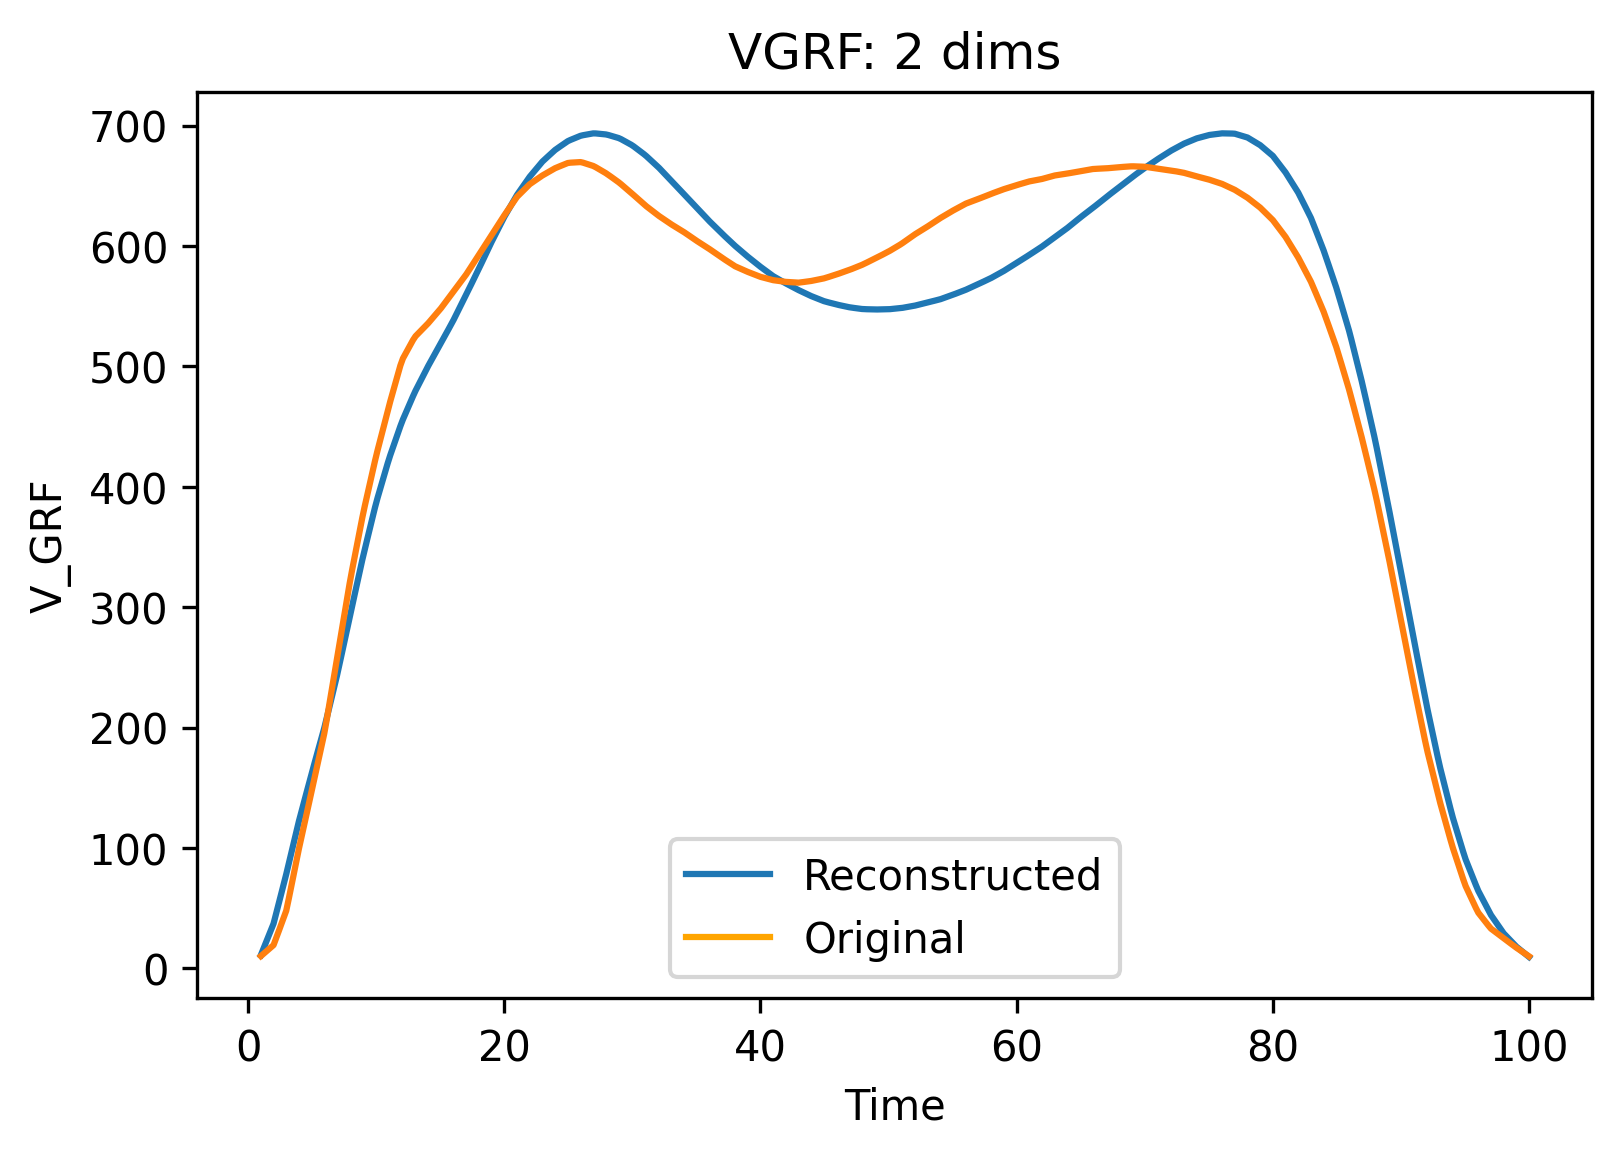

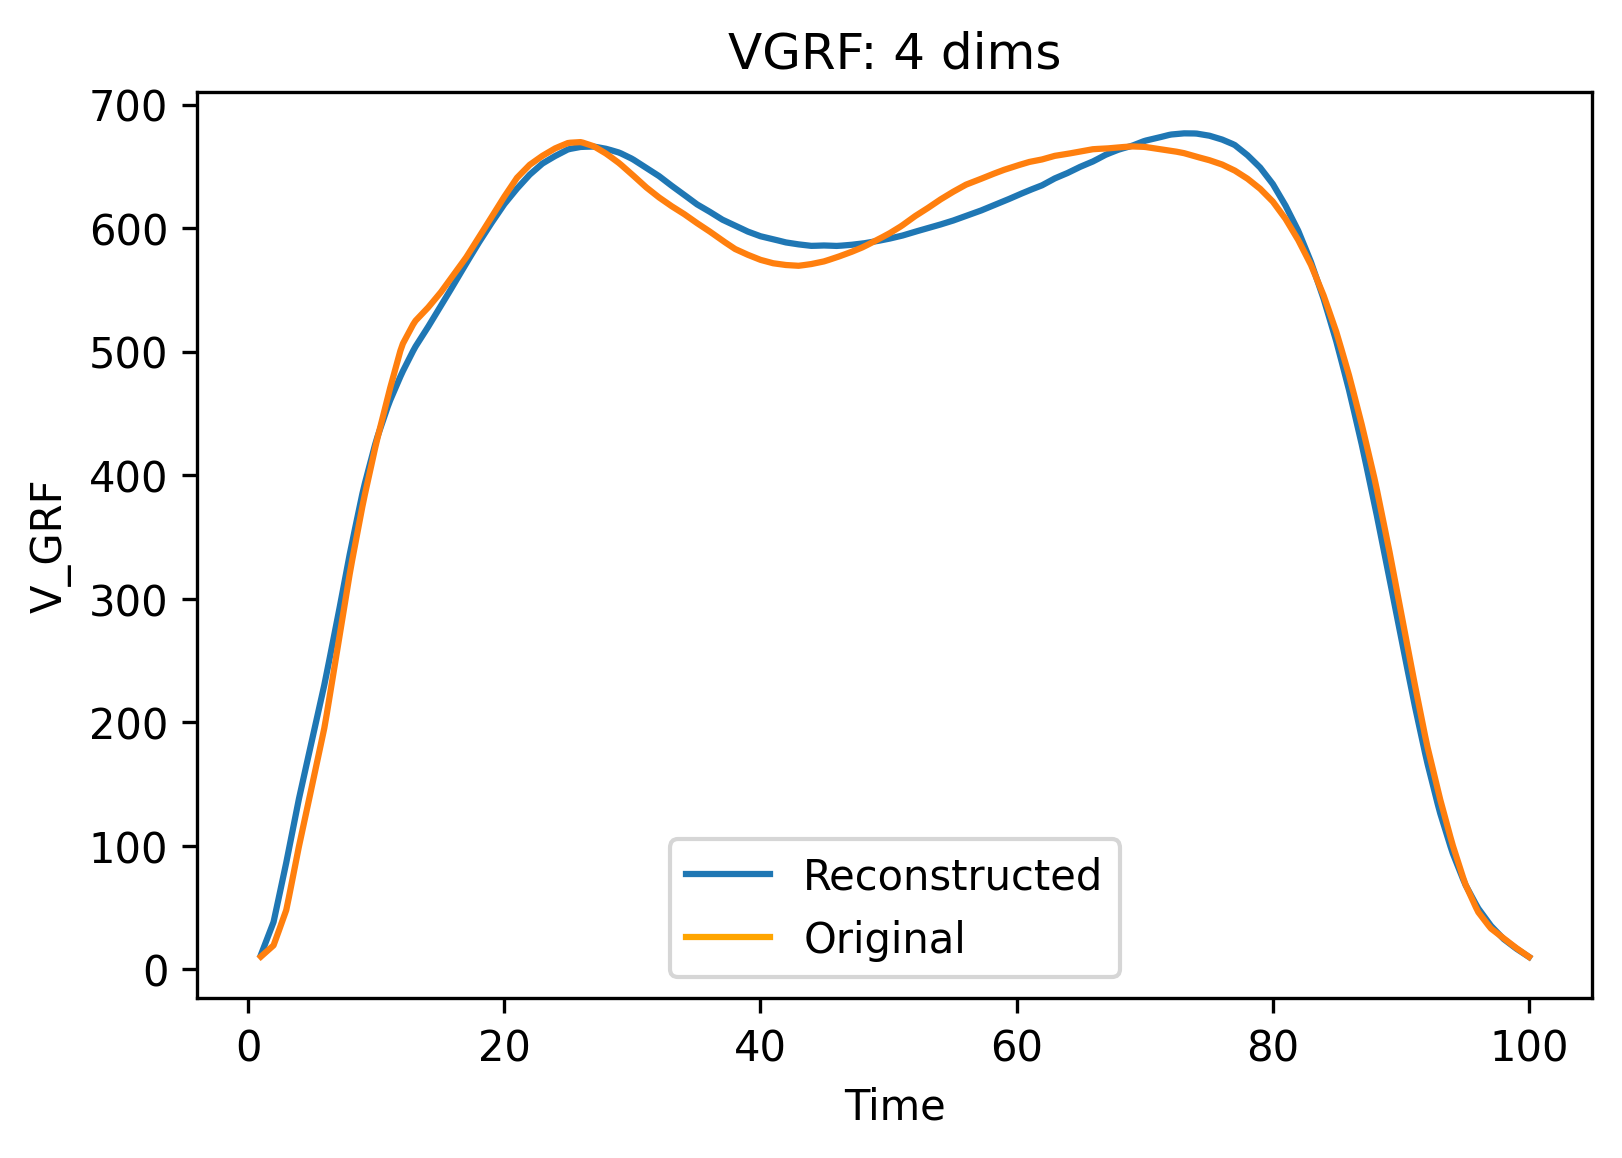

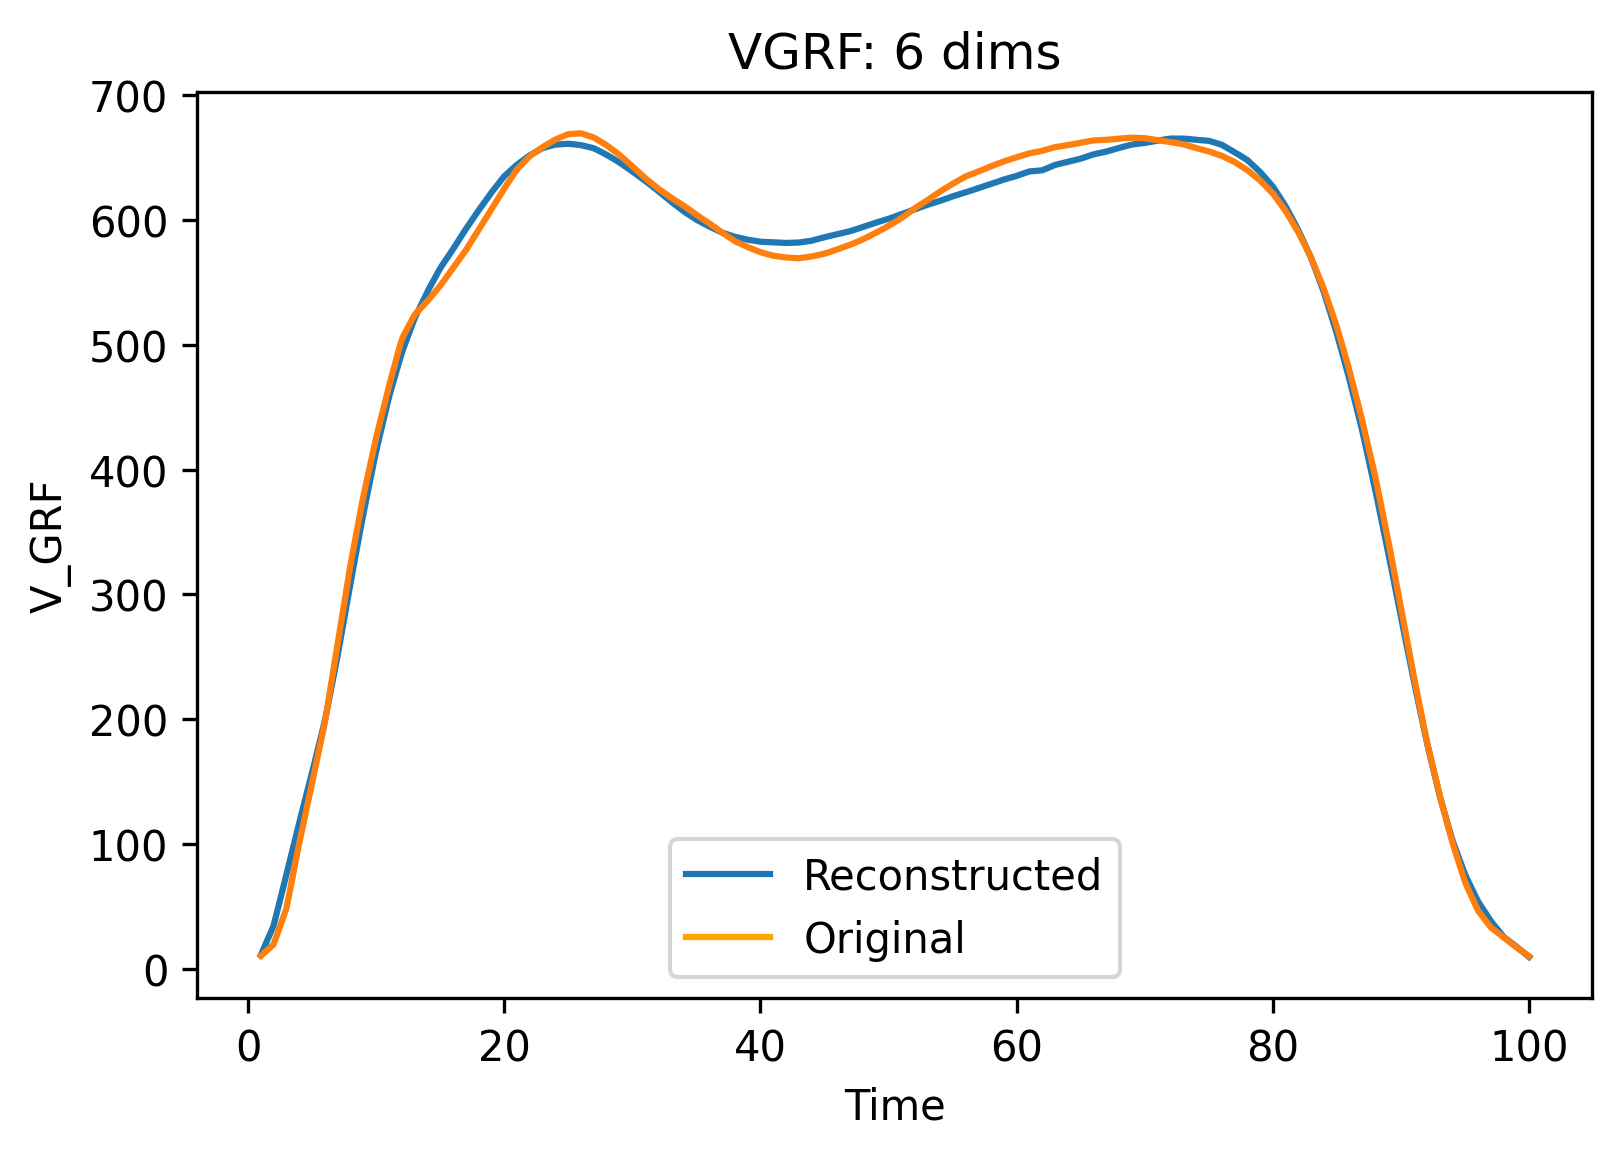

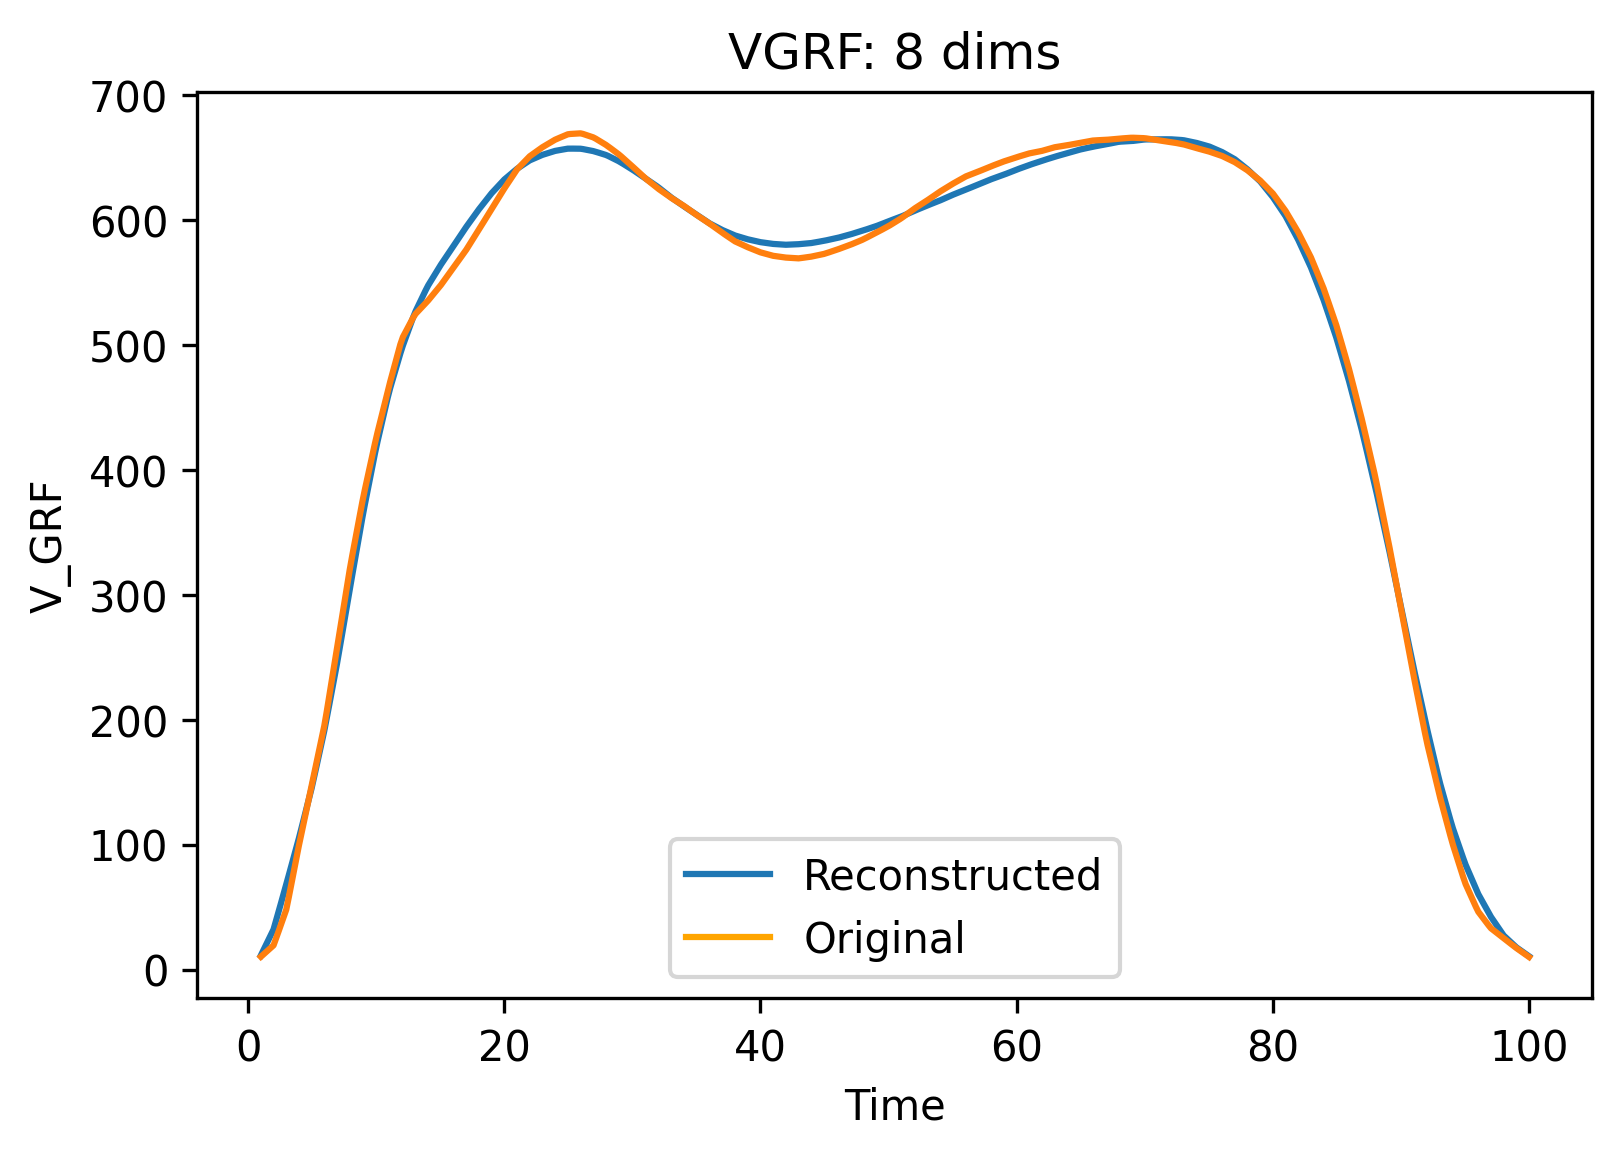

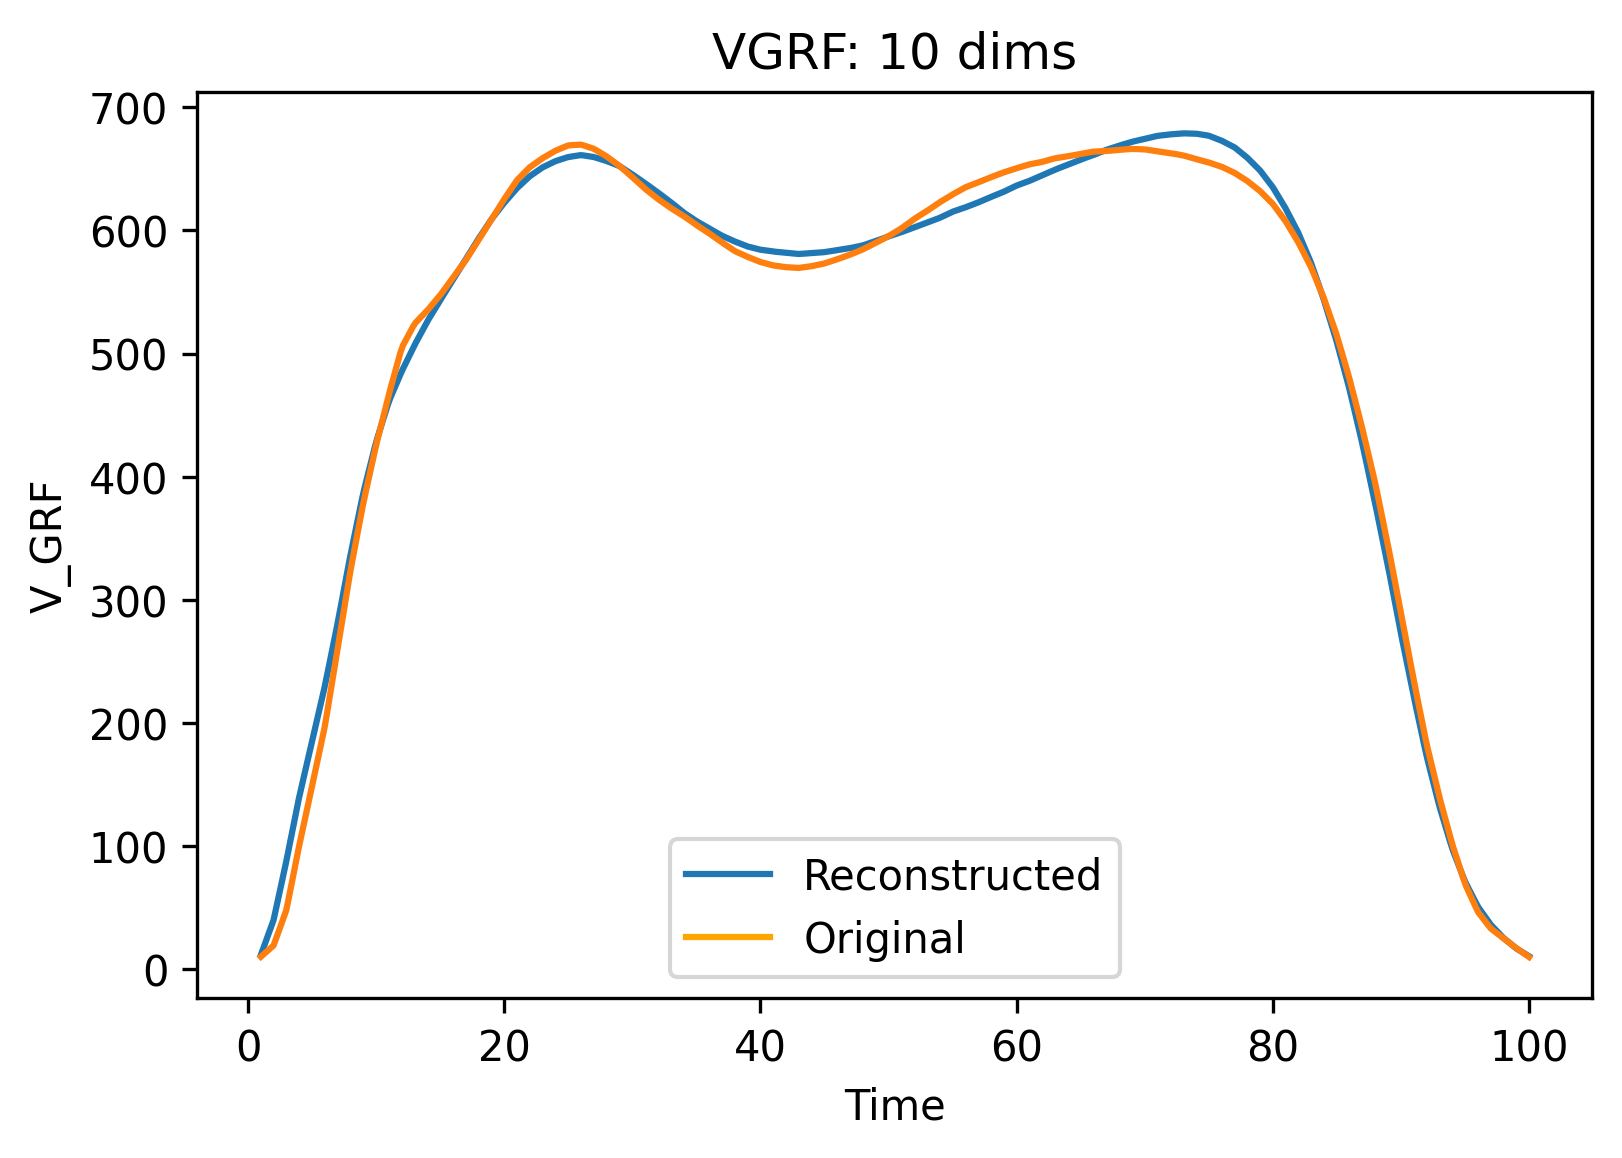

In [31]:
titles = ['VGRF: 2 dims','VGRF: 4 dims','VGRF: 6 dims','VGRF: 8 dims','VGRF: 10 dims']


legend_elements = [Line2D([0], [0], label='Reconstructed'), 
                   Line2D([0], [0], color='orange', label='Original')]

for i in range(5):
    fig = comb_fd[i].plot()
    fig.show()
    plt.title(titles[i])
    plt.xlabel("Time")
    plt.ylabel("V_GRF")
    plt.legend(handles = legend_elements)

# Latent Space Analysis

In [32]:
with torch.no_grad():
    recondata, latentmu, latentlv = models_npars[0](torch.tensor(V_GRF_stance_N_matrix, dtype=torch.float32))
    recondata = recondata.numpy()
    latentmu = latentmu.numpy()
    latentlv = latentlv.numpy()

In [33]:
latent_PCA = PCA()
latent_PCA.fit(latentmu[trainidx])
latentmu_PCA = latent_PCA.transform(latentmu)

In [34]:
lof = LocalOutlierFactor()
lof.fit(latentmu_PCA)
outidx = np.argsort(lof.negative_outlier_factor_)

In [35]:
for i in range(10):
    j = outidx[i]
    print('O%i | ID : %i | Trial: %i | Leg: %s | Trial Length: %i' % (i+1, int(ID_info_matrix[j,0]), int(ID_info_matrix[j,2]), ID_info_matrix[j,1] , int(ID_info_matrix[j,3])))

O1 | ID : 377 | Trial: 5 | Leg: RIGHT | Trial Length: 775
O2 | ID : 455 | Trial: 5 | Leg: RIGHT | Trial Length: 728
O3 | ID : 2008 | Trial: 5 | Leg: LEFT | Trial Length: 664
O4 | ID : 378 | Trial: 3 | Leg: LEFT | Trial Length: 632
O5 | ID : 414 | Trial: 4 | Leg: LEFT | Trial Length: 640
O6 | ID : 612 | Trial: 3 | Leg: LEFT | Trial Length: 886
O7 | ID : 1177 | Trial: 5 | Leg: LEFT | Trial Length: 794
O8 | ID : 571 | Trial: 5 | Leg: LEFT | Trial Length: 671
O9 | ID : 603 | Trial: 2 | Leg: RIGHT | Trial Length: 495
O10 | ID : 612 | Trial: 4 | Leg: LEFT | Trial Length: 860


In [36]:
def plot_outliers(subsel, offset=3):
    V_GRF_stance_N_out = V_GRF_stance_N_matrix[outidx[subsel]].copy()
#    weigout = spec_weig[outidx[subsel]]

    V_GRF_stance_N_out /= np.mean(np.abs(V_GRF_stance_N_out), axis=1)[:,None]
    V_GRF_stance_N_outfil = V_GRF_stance_N_out.copy()
#    specoutfil[weigout == 0] = float('nan')

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for i in range(len(subsel)):
        plt.plot(grid_points_100, V_GRF_stance_N_out[i] + offset*i, zorder=-i-0.01, c=colors[subsel[i]], alpha=0.5)
        plt.plot(grid_points_100, V_GRF_stance_N_outfil[i] + offset*i, zorder=-i, c=colors[subsel[i]])
        plt.text(grid_points_100[-1], V_GRF_stance_N_out[i,-1] + i*offset, 'O%i' % (subsel[i]+1), color=colors[subsel[i]], fontsize='small')
#    plt.xlim((3250,8800))

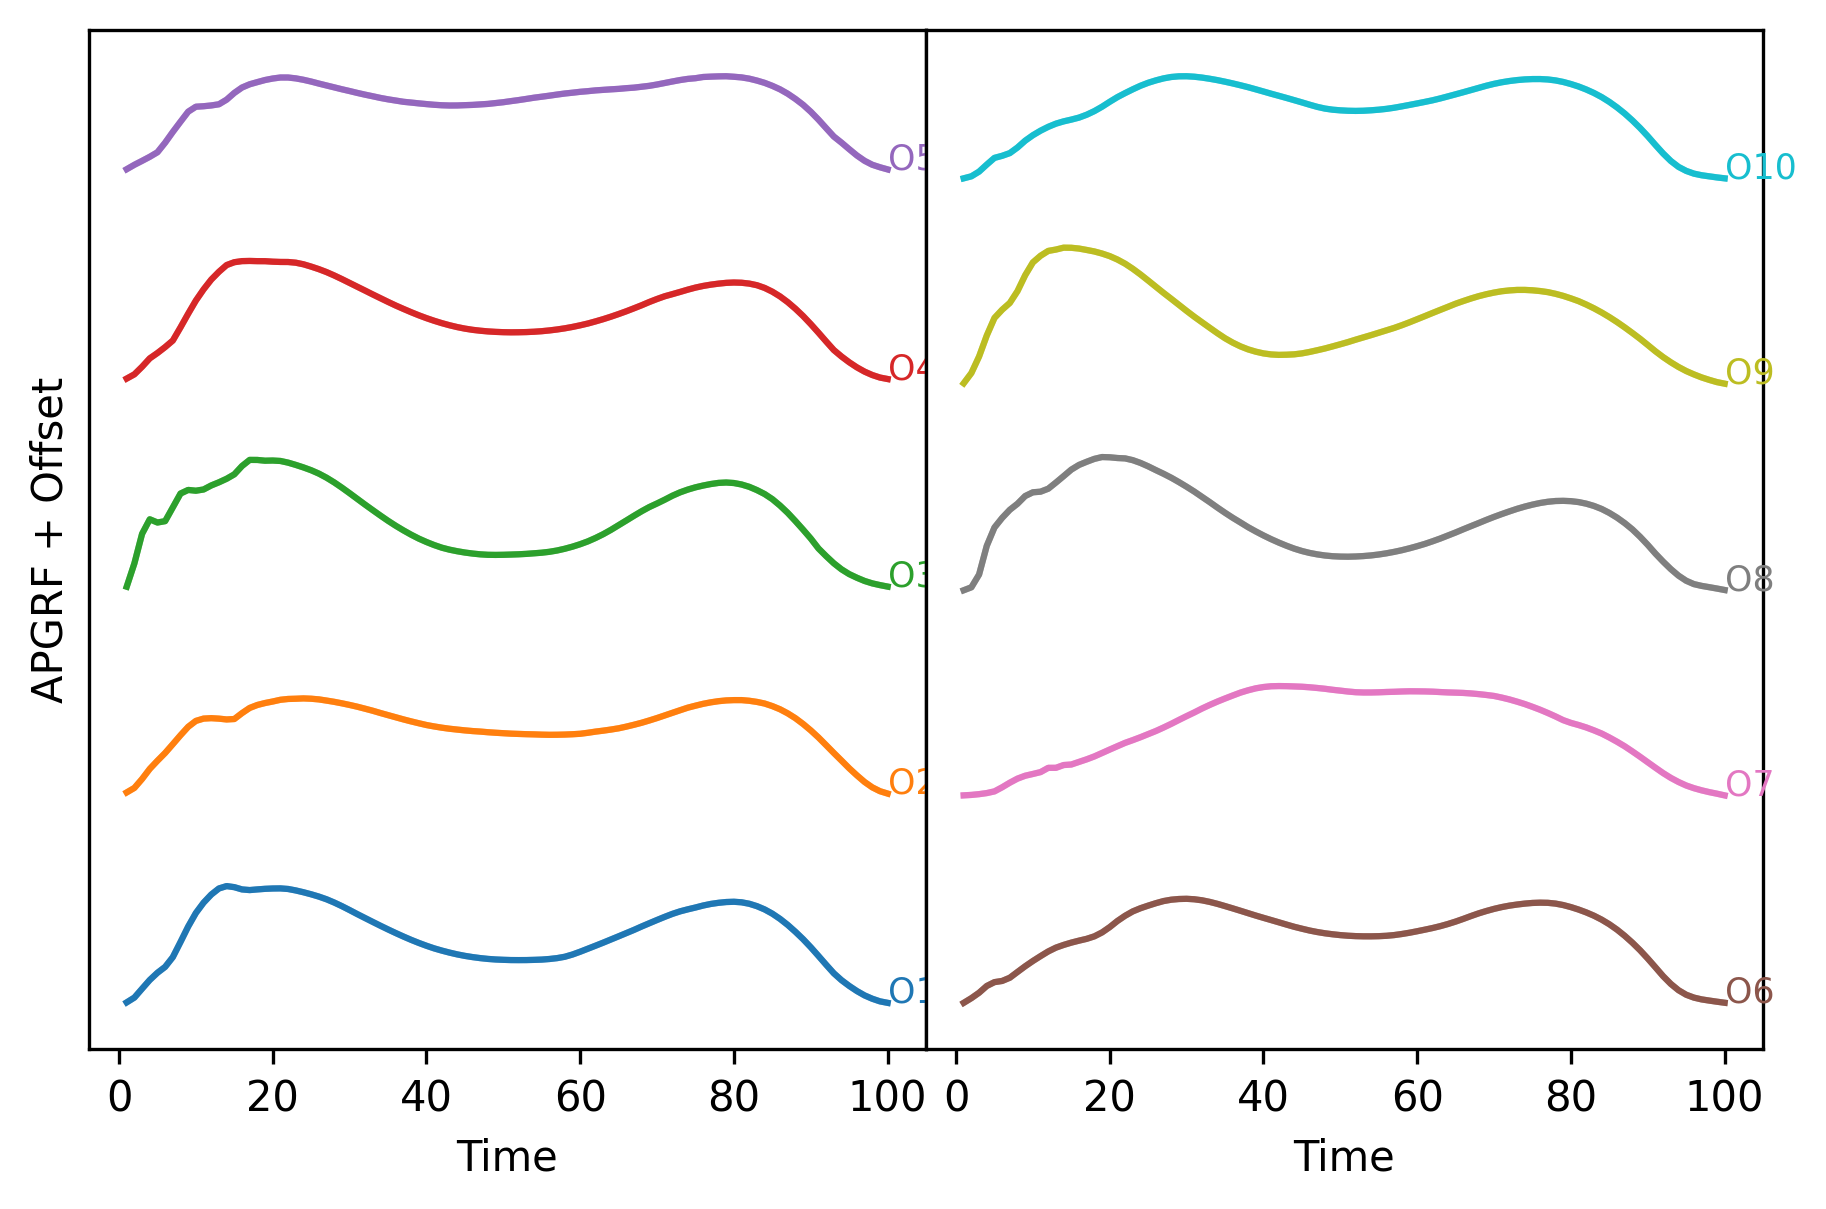

In [37]:
fig = plt.figure(figsize=(7.2,4.5), dpi=300)
fig.subplots_adjust(hspace=0, wspace=0)
plt.subplot(1,2,1)
plt.ylabel('APGRF + Offset')
plt.yticks([])
plt.xlabel('Time')
plot_outliers(range(0,5))
plt.subplot(1,2,2)
plot_outliers(range(5,10))
plt.yticks([])
plt.xlabel('Time')
#plt.savefig('figures/outliers.pdf')
plt.show()